# CMIP6 seasonal cycles

In different regions of the continental shelf, for 1958-1978 and 2081-2100

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import scipy.stats as st
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.lines import Line2D
from xarrayMannKendall import *

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '/home/561/jn8053/g_e14/figures-tmp/'

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:34277 Dashboard: /proxy/39331/status,Cluster Workers: 6 Cores: 24 Memory: 250.00 GiB


In [2]:
# Font size
plt.rcParams['font.size'] = 16
# Axes
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
# Saving parameters
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

def change_lon_space(ds, grid):
    if grid == 'u':
        ds = ds.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
        ds['_lon_adj'] = xr.where(ds['lon'] < 0, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    elif grid == 't':
        ds = ds.rename(({'xt_ocean':'lon', 'yt_ocean':'lat'}))
        ds['_lon_adj'] = xr.where(ds['lon'] < 0, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    else:
        ds['_lon_adj'] = xr.where(ds['lon'] < 0, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    return ds

In [3]:
uas = {}; vas = {}
names = []
# Load baseline period 
uas['hist', 'JRA'] = xr.open_dataset('/scratch/e14/jn8053/jra55/uas-v14-monthly-1958_2019.nc').sel(lat = slice(None, -50)).sel(time = slice(None, '1978-01-01')).groupby('time.month').mean('time')
vas['hist', 'JRA'] = xr.open_dataset('/scratch/e14/jn8053/jra55/vas-v14-monthly-1958_2019.nc').sel(lat = slice(None, -50)).sel(time = slice(None, '1978-01-01')).groupby('time.month').mean('time')
uas['hist', 'CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/historical/uas-hist-monthly-1958_2015.nc').sel(time = slice(None, '1978-01-01')).groupby('time.month').mean('time')
vas['hist', 'CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/historical/vas-hist-monthly-1958_2015.nc').sel(time = slice(None, '1978-01-01')).groupby('time.month').mean('time')
path_uas = glob.glob('/scratch/e14/jn8053/cmip6/historical/uas/uas*')
path_vas = glob.glob('/scratch/e14/jn8053/cmip6/historical/vas/vas*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas['hist', model_name] = xr.open_dataset(path_uas[i]).sel(time = slice(None, '1978-01-01')).groupby('time.month').mean('time')
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas['hist', model_name] = xr.open_dataset(path_vas[i]).sel(time = slice(None, '1978-01-01')).groupby('time.month').mean('time')
    names.append(model_name)
    
# Load projections period
uas['ssp4', 'CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/ssp4.5/uas-ssp4.5-monthly-2015_2100.nc').sel(time = slice('2081-01-01', None)).groupby('time.month').mean('time')
vas['ssp4', 'CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/ssp4.5/vas-ssp4.5-monthly-2015_2100.nc').sel(time = slice('2081-01-01', None)).groupby('time.month').mean('time')
path_uas = glob.glob('/scratch/e14/jn8053/cmip6/ssp4.5/uas/uas*')
path_vas = glob.glob('/scratch/e14/jn8053/cmip6/ssp4.5/vas/vas*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    uas['ssp4', model_name] = xr.open_dataset(path_uas[i]).sel(time = slice('2081-01-01', None)).groupby('time.month').mean('time')
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    vas['ssp4', model_name] = xr.open_dataset(path_vas[i]).sel(time = slice('2081-01-01', None)).groupby('time.month').mean('time')
    
uas['ssp8', 'CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/ssp8.5/uas-ssp8.5-monthly-2015_2100.nc').sel(time = slice('2081-01-01', None)).groupby('time.month').mean('time')
vas['ssp8', 'CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/ssp8.5/vas-ssp8.5-monthly-2015_2100.nc').sel(time = slice('2081-01-01', None)).groupby('time.month').mean('time')
path_uas = glob.glob('/scratch/e14/jn8053/cmip6/ssp8.5/uas/uas*')
path_vas = glob.glob('/scratch/e14/jn8053/cmip6/ssp8.5/vas/vas*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    uas['ssp8', model_name] = xr.open_dataset(path_uas[i]).sel(time = slice('2081-01-01', None)).groupby('time.month').mean('time')
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    vas['ssp8', model_name] = xr.open_dataset(path_vas[i]).sel(time = slice('2081-01-01', None)).groupby('time.month').mean('time')

In [4]:
shelf_regions = xr.open_dataset('~/g_e14/misc/Antarctic_shelf_basins.nc')
shelf_regions = change_lon_space(shelf_regions, 't')
basins = shelf_regions['basins'].where(shelf_regions['basins'] != 100, np.nan)

In [5]:
locs = list(shelf_regions['basin_lookup']['region'][:-1].values)
locs.remove('East Antarctica 04')

# Historical period

In [16]:
legend_elements = [Line2D([0], [0], color = 'k', ls = '--', label = 'JRA'),
                   Line2D([0], [0], color = 'k', ls = '-', label = 'CMIP6 mean')]

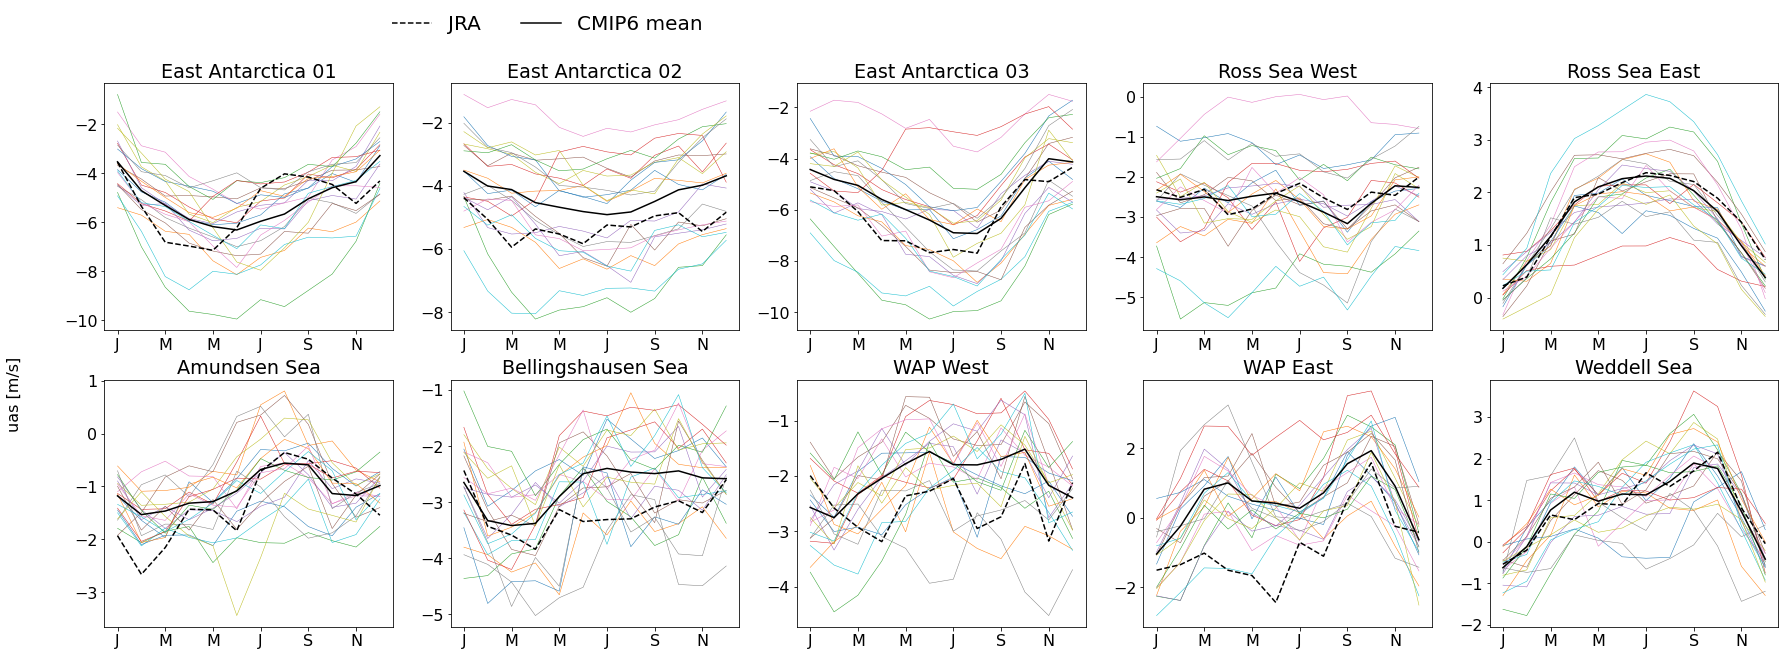

In [17]:
fig = plt.figure(figsize = (30, 10))
gr = gs.GridSpec(2, 5, figure = fig)
axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[0,1]), fig.add_subplot(gr[0,2]), fig.add_subplot(gr[0,3]),
       fig.add_subplot(gr[0,4]), fig.add_subplot(gr[1,0]), fig.add_subplot(gr[1,1]), fig.add_subplot(gr[1,2]),
       fig.add_subplot(gr[1,3]), fig.add_subplot(gr[1,4])];
n = 2
for r in locs:
    for name in names:
        b = basins.interp(lon = uas['hist', name]['lon'], lat = uas['hist', name]['lat'])
        u = uas['hist', name]['uas'].where(b == n, np.nan).mean(['lon', 'lat'])
        axs[n-2].plot(np.arange(0,12,1), u, linewidth = .5)
        axs[n-2].set_title(r)
        
    b = basins.interp(lon = uas['hist', 'CMIP6']['lon'], lat = uas['hist', 'CMIP6']['lat'])
    u = uas['hist', 'CMIP6']['uas'].where(b == n, np.nan).mean(['lon', 'lat'])
    axs[n-2].plot(np.arange(0,12,1), u, 'k', linewidth = 1.5)
    b = basins.interp(lon = uas['hist', 'JRA']['lon'], lat = uas['hist', 'JRA']['lat'])
    u = uas['hist', 'JRA']['uas'].where(b == n, np.nan).mean(['lon', 'lat'])
    axs[n-2].plot(np.arange(0,12,1), u, 'k', linewidth = 1.5, linestyle = '--')
    axs[n-2].set_xticks(np.arange(0, 12, 2))
    axs[n-2].set_xticklabels(['J', 'M', 'M', 'J', 'S', 'N'])
    n += 1
fig.text(0.08, .4, 'uas [m/s]', rotation = 90) 
fig.legend(handles = legend_elements, ncol = 4, loc = 'upper left', bbox_to_anchor = (.25, 1), fontsize = 20, frameon = False)
plt.savefig(figdir+'/easterlies-collaborative/uas-seasonal_cycle-regions-jra-cmip6.png', facecolor = 'white', bbox_inches = 'tight')

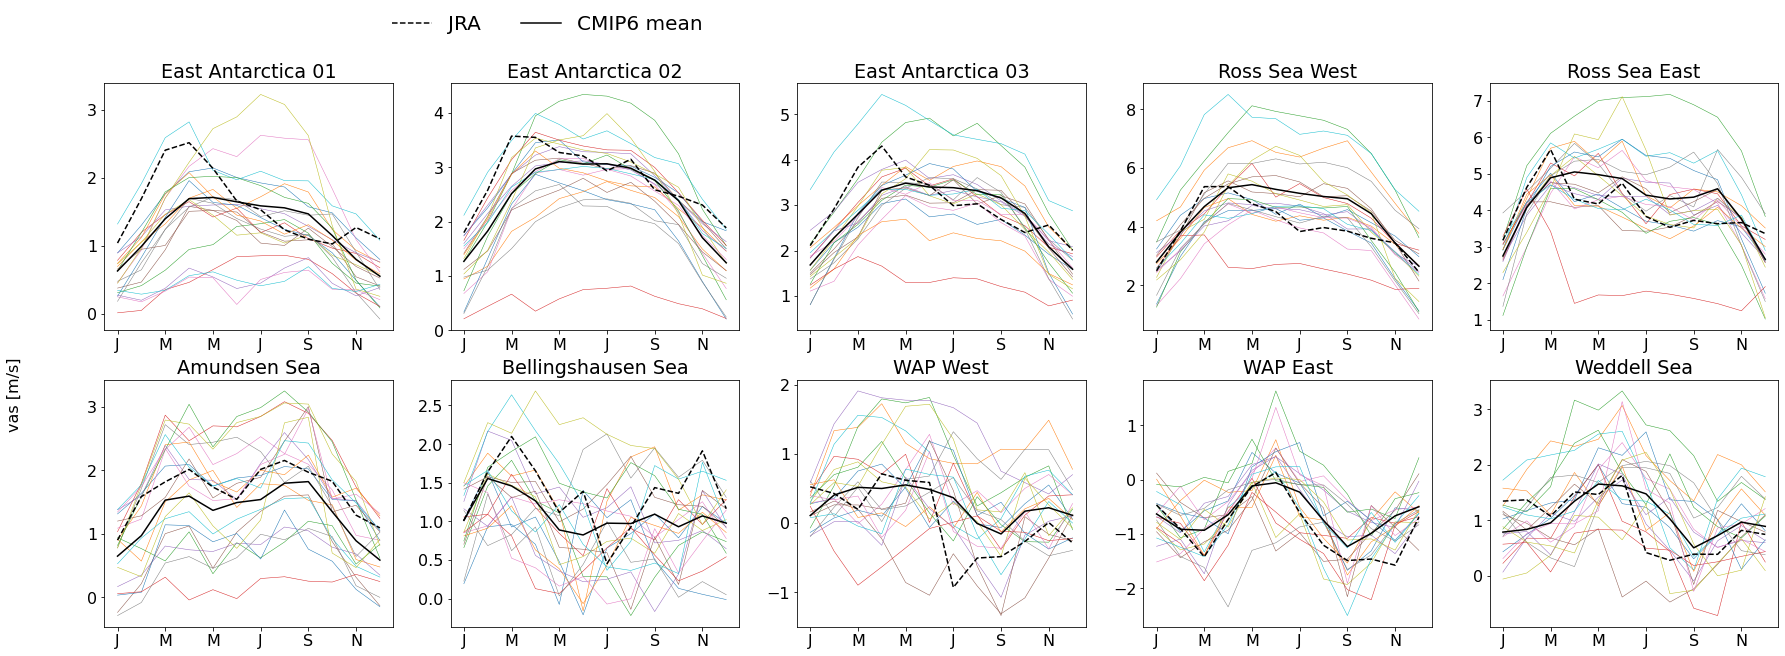

In [20]:
fig = plt.figure(figsize = (30, 10))
gr = gs.GridSpec(2, 5, figure = fig)
axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[0,1]), fig.add_subplot(gr[0,2]), fig.add_subplot(gr[0,3]),
       fig.add_subplot(gr[0,4]), fig.add_subplot(gr[1,0]), fig.add_subplot(gr[1,1]), fig.add_subplot(gr[1,2]),
       fig.add_subplot(gr[1,3]), fig.add_subplot(gr[1,4])];
n = 2
for r in locs:
    for name in names:
        b = basins.interp(lon = vas['hist', name]['lon'], lat = vas['hist', name]['lat'])
        u = vas['hist', name]['vas'].where(b == n, np.nan).mean(['lon', 'lat'])
        axs[n-2].plot(np.arange(0,12,1), u, linewidth = .5)
        axs[n-2].set_title(r)
        
    b = basins.interp(lon = vas['hist', 'CMIP6']['lon'], lat = vas['hist', 'CMIP6']['lat'])
    u = vas['hist', 'CMIP6']['vas'].where(b == n, np.nan).mean(['lon', 'lat'])
    axs[n-2].plot(np.arange(0,12,1), u, 'k', linewidth = 1.5)
    b = basins.interp(lon = vas['hist', 'JRA']['lon'], lat = vas['hist', 'JRA']['lat'])
    u = vas['hist', 'JRA']['vas'].where(b == n, np.nan).mean(['lon', 'lat'])
    axs[n-2].plot(np.arange(0,12,1), u, 'k', linewidth = 1.5, linestyle = '--')
    axs[n-2].set_xticks(np.arange(0, 12, 2))
    axs[n-2].set_xticklabels(['J', 'M', 'M', 'J', 'S', 'N'])
    n += 1
fig.text(0.08, .4, 'vas [m/s]', rotation = 90) 
fig.legend(handles = legend_elements, ncol = 4, loc = 'upper left', bbox_to_anchor = (.25, 1), fontsize = 20, frameon = False)
plt.savefig(figdir+'/easterlies-collaborative/vas-seasonal_cycle-regions-jra-cmip6.png', facecolor = 'white', bbox_inches = 'tight')

# SSP2-4.5

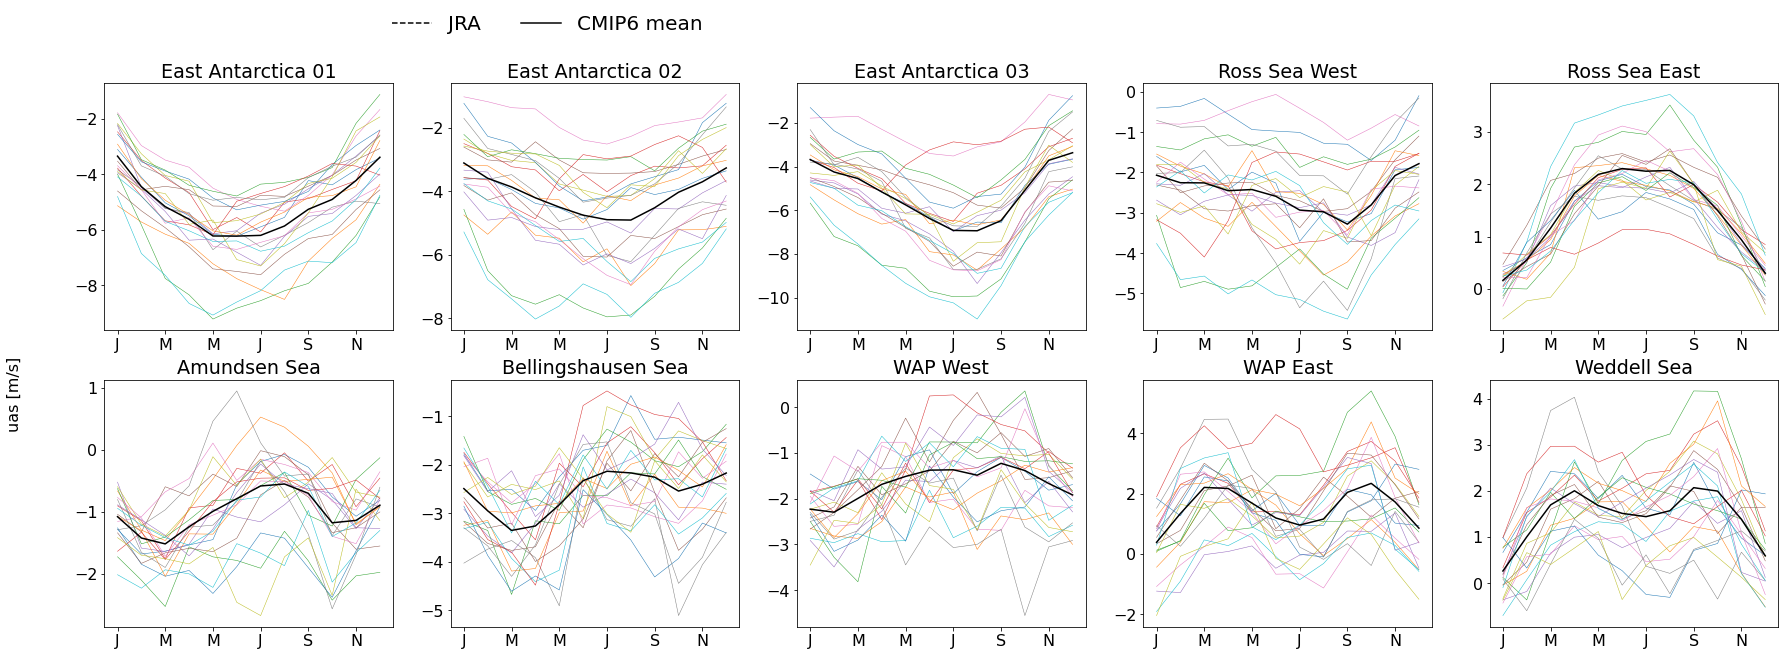

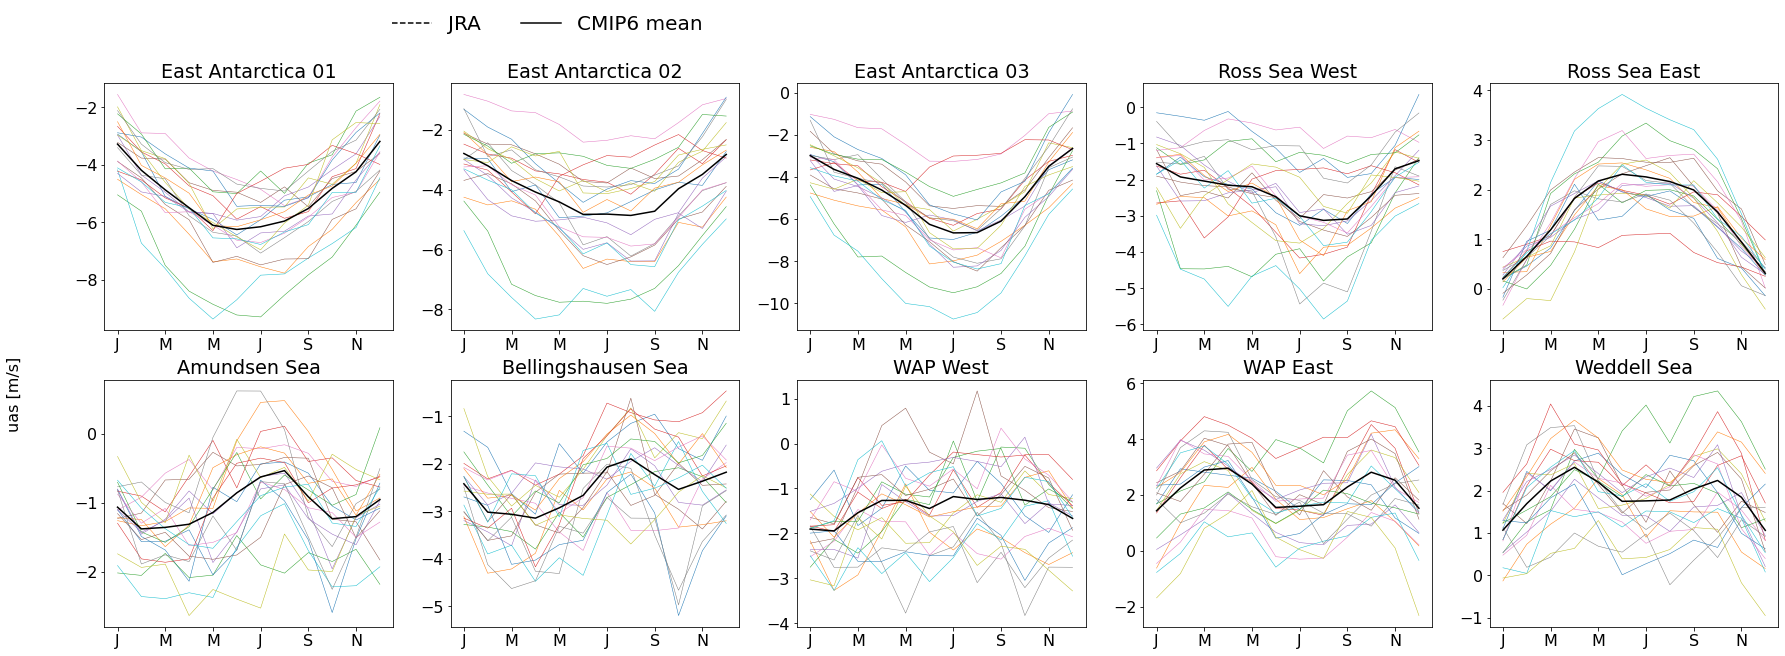

In [23]:
for scen in ['ssp4', 'ssp8']:
    fig = plt.figure(figsize = (30, 10))
    gr = gs.GridSpec(2, 5, figure = fig)
    axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[0,1]), fig.add_subplot(gr[0,2]), fig.add_subplot(gr[0,3]),
           fig.add_subplot(gr[0,4]), fig.add_subplot(gr[1,0]), fig.add_subplot(gr[1,1]), fig.add_subplot(gr[1,2]),
           fig.add_subplot(gr[1,3]), fig.add_subplot(gr[1,4])];
    n = 2
    for r in locs:
        for name in names:
            b = basins.interp(lon = uas[scen, name]['lon'], lat = uas[scen, name]['lat'])
            u = uas[scen, name]['uas'].where(b == n, np.nan).mean(['lon', 'lat'])
            axs[n-2].plot(np.arange(0,12,1), u, linewidth = .5)
            axs[n-2].set_title(r)

        b = basins.interp(lon = uas[scen, 'CMIP6']['lon'], lat = uas[scen, 'CMIP6']['lat'])
        u = uas[scen, 'CMIP6']['uas'].where(b == n, np.nan).mean(['lon', 'lat'])
        axs[n-2].plot(np.arange(0,12,1), u, 'k', linewidth = 1.5)
        axs[n-2].set_xticks(np.arange(0, 12, 2))
        axs[n-2].set_xticklabels(['J', 'M', 'M', 'J', 'S', 'N'])
        n += 1
    fig.text(0.08, .4, 'uas [m/s]', rotation = 90) 
    fig.legend(handles = legend_elements, ncol = 4, loc = 'upper left', bbox_to_anchor = (.25, 1), fontsize = 20, frameon = False)
    plt.savefig(figdir+'/easterlies-collaborative/uas-seasonal_cycle-'+scen+'.5-regions-jra-cmip6.png', facecolor = 'white', bbox_inches = 'tight')

# Altogether

In [28]:
legend_elements = [Line2D([0], [0], color = 'k', ls = '-', label = 'Historical CMIP6 MMM'),
                   Line2D([0], [0], color = 'lightsteelblue', ls = '-', label = 'SSP2-4.5 CMIP6 MMM'),
                   Line2D([0], [0], color = 'lightcoral', ls = '-', label = 'SSP5-8.5 CMIP6 MMM')]

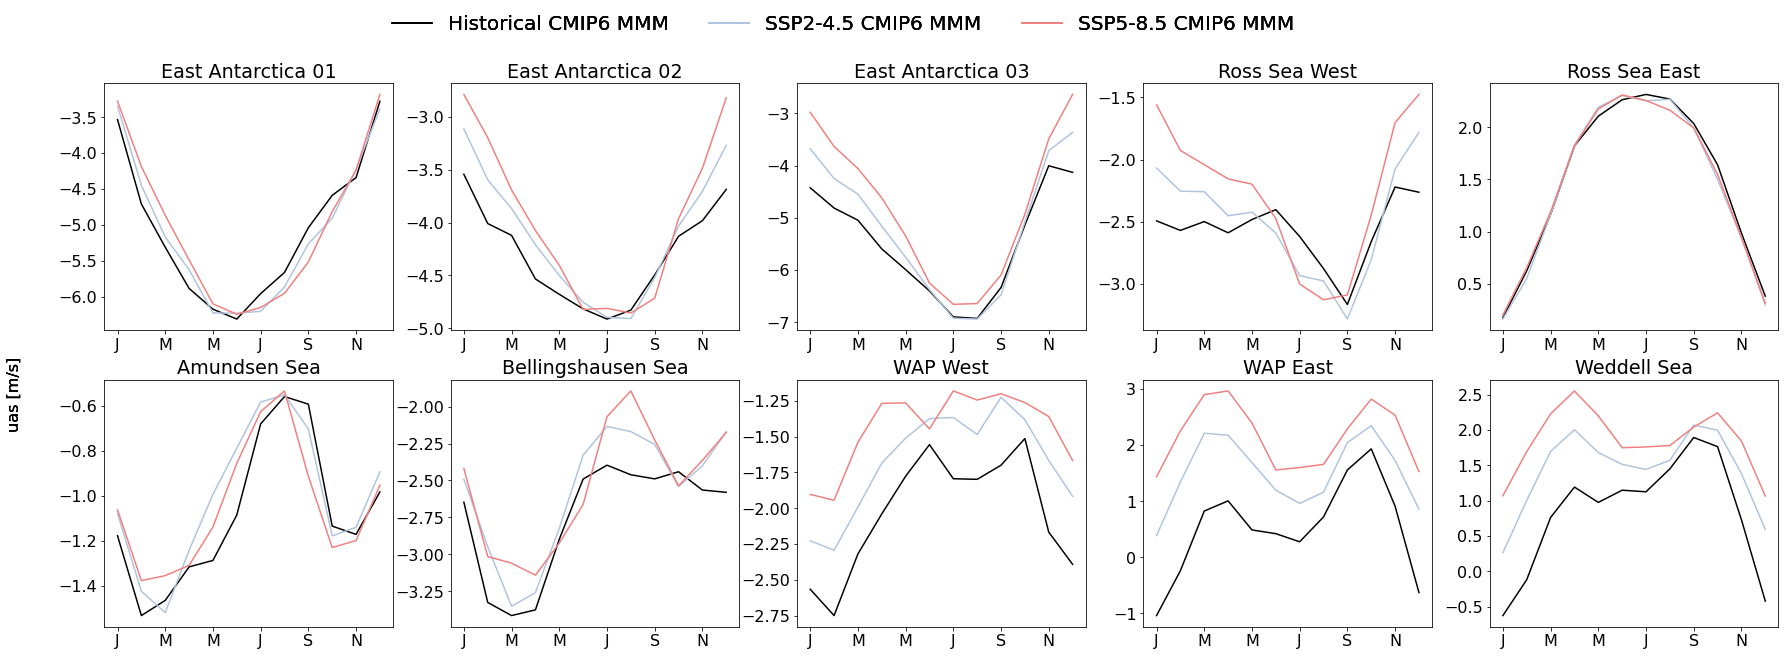

In [31]:
fig = plt.figure(figsize = (30, 10))
gr = gs.GridSpec(2, 5, figure = fig)
axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[0,1]), fig.add_subplot(gr[0,2]), fig.add_subplot(gr[0,3]),
       fig.add_subplot(gr[0,4]), fig.add_subplot(gr[1,0]), fig.add_subplot(gr[1,1]), fig.add_subplot(gr[1,2]),
       fig.add_subplot(gr[1,3]), fig.add_subplot(gr[1,4])];
for scen, c in zip(['hist', 'ssp4', 'ssp8'], ['k', 'lightsteelblue', 'lightcoral']):
    n = 2
    for r in locs:
        axs[n-2].set_title(r)
        b = basins.interp(lon = uas[scen, 'CMIP6']['lon'], lat = uas[scen, 'CMIP6']['lat'])
        u = uas[scen, 'CMIP6']['uas'].where(b == n, np.nan).mean(['lon', 'lat'])
        axs[n-2].plot(np.arange(0,12,1), u, color = c, linewidth = 1.5)
        axs[n-2].set_xticks(np.arange(0, 12, 2))
        axs[n-2].set_xticklabels(['J', 'M', 'M', 'J', 'S', 'N'])
        n += 1
    fig.text(0.08, .4, 'uas [m/s]', rotation = 90) 
    fig.legend(handles = legend_elements, ncol = 4, loc = 'upper left', bbox_to_anchor = (.25, 1), fontsize = 20, frameon = False)
plt.savefig(figdir+'/easterlies-collaborative/uas-seasonal_cycle-allscen_vs_hist-regions-jra-cmip6.png', facecolor = 'white', bbox_inches = 'tight')

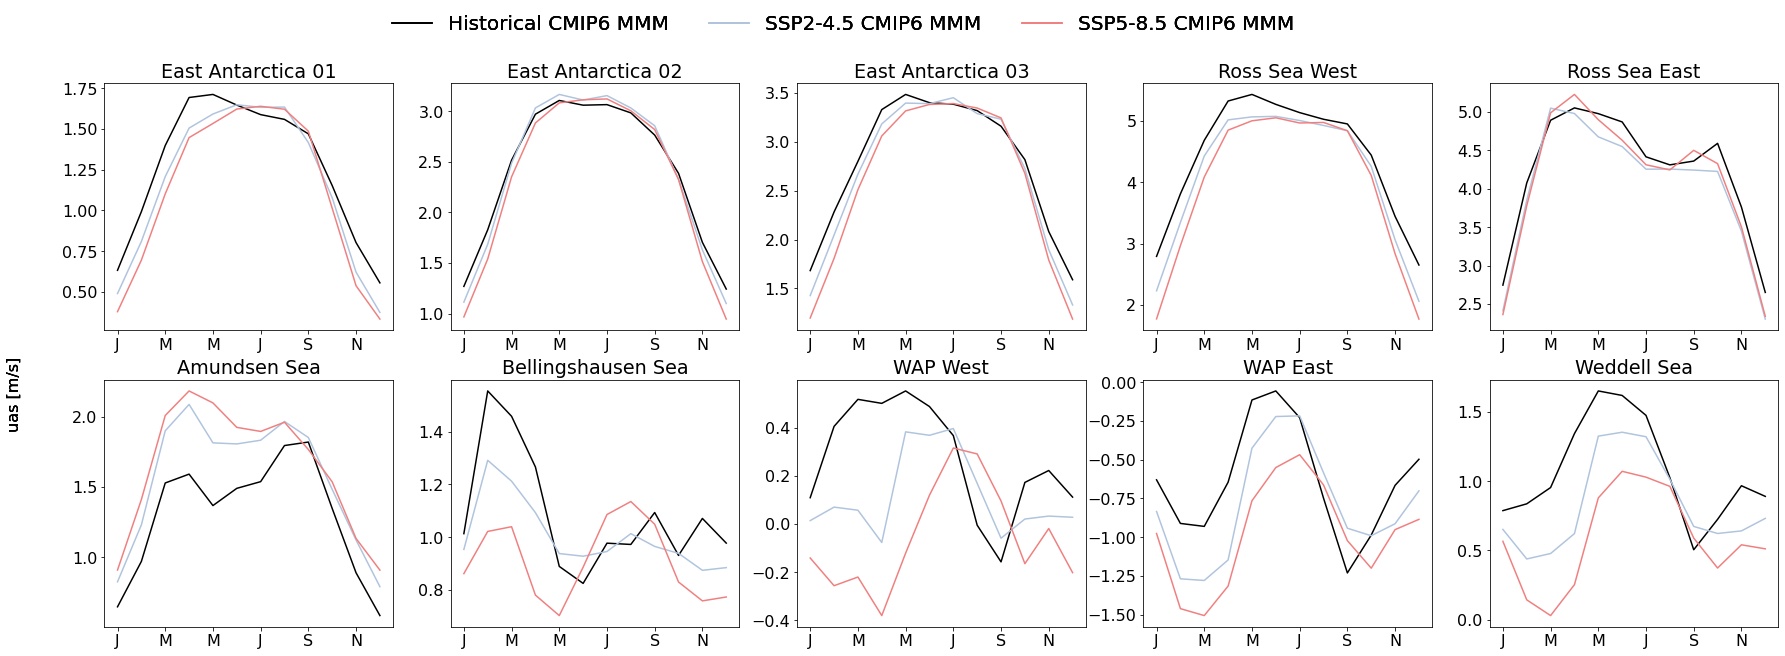

In [32]:
fig = plt.figure(figsize = (30, 10))
gr = gs.GridSpec(2, 5, figure = fig)
axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[0,1]), fig.add_subplot(gr[0,2]), fig.add_subplot(gr[0,3]),
       fig.add_subplot(gr[0,4]), fig.add_subplot(gr[1,0]), fig.add_subplot(gr[1,1]), fig.add_subplot(gr[1,2]),
       fig.add_subplot(gr[1,3]), fig.add_subplot(gr[1,4])];
for scen, c in zip(['hist', 'ssp4', 'ssp8'], ['k', 'lightsteelblue', 'lightcoral']):
    n = 2
    for r in locs:
        axs[n-2].set_title(r)
        b = basins.interp(lon = vas[scen, 'CMIP6']['lon'], lat = vas[scen, 'CMIP6']['lat'])
        u = vas[scen, 'CMIP6']['vas'].where(b == n, np.nan).mean(['lon', 'lat'])
        axs[n-2].plot(np.arange(0,12,1), u, color = c, linewidth = 1.5)
        axs[n-2].set_xticks(np.arange(0, 12, 2))
        axs[n-2].set_xticklabels(['J', 'M', 'M', 'J', 'S', 'N'])
        n += 1
    fig.text(0.08, .4, 'uas [m/s]', rotation = 90) 
    fig.legend(handles = legend_elements, ncol = 4, loc = 'upper left', bbox_to_anchor = (.25, 1), fontsize = 20, frameon = False)
plt.savefig(figdir+'/easterlies-collaborative/vas-seasonal_cycle-allscen_vs_hist-regions-jra-cmip6.png', facecolor = 'white', bbox_inches = 'tight')